# Binary Neural Network (BNN) for Plant Disease Classification

This notebook implements a Binary Neural Network using PyTorch for multiclass plant disease classification. The BNN uses binary weights and activations to reduce model size and computational requirements while maintaining reasonable accuracy.

## Features:
- Binary weights and activations using sign function
- Processes 64x64 RGB images (3×64×64 input)
- One hidden layer with binary weights
- Multiclass output with softmax activation
- CrossEntropyLoss for training

In [2]:
# Import Required Libraries
# %pip install torch torchvision matplotlib numpy pandas seaborn scikit-learn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Create results directory
os.makedirs('results_og_opt', exist_ok=True)
print("Results directory created: ./results_og_opt/")

Results directory created: ./results/


In [4]:
# Binary Activation Function
class BinaryActivation(torch.autograd.Function):
    """
    Binary activation function using the sign function.
    Forward: sign(x) = {-1 if x < 0, +1 if x >= 0}
    Backward: Straight-through estimator (STE) - passes gradients through unchanged
    """
    
    @staticmethod
    def forward(ctx, input):
        # Apply sign function: -1 for negative, +1 for non-negative
        return torch.sign(input)
    
    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through estimator: pass gradients through unchanged
        # This allows gradients to flow back during training
        return grad_output

def binary_activation(x):
    """Wrapper function for binary activation"""
    return BinaryActivation.apply(x)

In [5]:
# Binary Linear Layer
class BinaryLinear(nn.Module):
    """
    Binary Linear layer with binary weights.
    Weights are binarized using the sign function during forward pass.
    """
    
    def __init__(self, in_features, out_features, bias=True):
        super(BinaryLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights using normal distribution
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
    
    def forward(self, input):
        # Binarize weights using sign function
        binary_weight = torch.sign(self.weight)
        
        # Perform linear transformation with binary weights
        output = F.linear(input, binary_weight, self.bias)
        
        return output
    
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

In [6]:
# Binary Neural Network Model
class BinaryNeuralNetwork(nn.Module):
    """
    Binary Neural Network for multiclass plant disease classification.
    
    Architecture:
    - Input: Flattened 64x64 RGB images (3*64*64 = 12288 features)
    - Hidden Layer: Binary linear layer with binary activation
    - Output Layer: Regular linear layer for class logits
    - Final: Softmax for multiclass prediction
    """
    
    def __init__(self, input_size=3*64*64, hidden_size=512, num_classes=4):
        super(BinaryNeuralNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        
        # First layer: Regular linear layer (input preprocessing)
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Hidden layer: Binary linear layer
        self.hidden_layer = BinaryLinear(hidden_size, hidden_size)
        
        # Output layer: Regular linear layer for final classification
        self.output_layer = nn.Linear(hidden_size, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten input if it's not already flattened
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, input_size)
        
        # Input layer with ReLU activation
        x = F.relu(self.input_layer(x))
        x = self.dropout(x)
        
        # Hidden layer with binary weights and binary activation
        x = self.hidden_layer(x)
        x = binary_activation(x)  # Binary activation function
        x = self.dropout(x)
        
        # Output layer (no activation - raw logits)
        logits = self.output_layer(x)
        
        return logits
    
    def predict_proba(self, x):
        """Get class probabilities using softmax"""
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
        return probabilities
    
    def predict(self, x):
        """Get predicted class labels"""
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

In [7]:
# Enhanced Training and Evaluation Functions
def train_bnn(model, train_loader, criterion, optimizer, device, num_epochs=10):
    """
    Enhanced training function with detailed metrics collection
    """
    model.train()
    
    # Initialize tracking lists
    train_losses = []
    train_accuracies = []
    epoch_times = []
    learning_rates = []
    
    # Detailed metrics per epoch
    training_history = []
    
    print(f"Starting training for {num_epochs} epochs...")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        batch_losses = []
        
        # Training loop
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            batch_loss = loss.item()
            running_loss += batch_loss
            batch_losses.append(batch_loss)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_samples
        epoch_time = time.time() - epoch_start
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        epoch_times.append(epoch_time)
        learning_rates.append(current_lr)
        
        # Store detailed history
        training_history.append({
            'epoch': epoch + 1,
            'loss': epoch_loss,
            'accuracy': epoch_accuracy,
            'time': epoch_time,
            'learning_rate': current_lr,
            'min_batch_loss': min(batch_losses),
            'max_batch_loss': max(batch_losses),
            'std_batch_loss': np.std(batch_losses)
        })
        
        # Progress display
        print(f'Epoch [{epoch+1:2d}/{num_epochs}] | Loss: {epoch_loss:.4f} | '
              f'Acc: {epoch_accuracy:6.2f}% | Time: {epoch_time:.2f}s | LR: {current_lr:.6f}')
    
    total_time = time.time() - start_time
    print("-" * 60)
    print(f"Training completed in {total_time:.2f} seconds")
    print(f"Average epoch time: {np.mean(epoch_times):.2f}s")
    
    return train_losses, train_accuracies, training_history, epoch_times

def evaluate_bnn(model, test_loader, criterion, device, class_names):
    """
    Enhanced evaluation function with detailed metrics
    """
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            # Store for detailed analysis
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_predictions / total_samples
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    # Generate detailed classification report
    report = classification_report(all_targets, all_predictions, 
                                 target_names=class_names, output_dict=True)
    
    # Calculate per-class metrics
    precision, recall, fscore, support = precision_recall_fscore_support(
        all_targets, all_predictions, average=None, labels=range(len(class_names))
    )
    
    # Create detailed metrics dictionary
    detailed_metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities,
        'classification_report': report,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_fscore': fscore,
        'per_class_support': support
    }
    
    return detailed_metrics

In [8]:
# Load Real Plant Disease Dataset
from torchvision import datasets, transforms
from PIL import Image
import os

def load_plant_disease_dataset(dataset_path, image_size=64):
    """
    Load the real plant disease dataset from the specified path.
    Dataset structure:
    - dataset_path/healthy/
    - dataset_path/rust/
    - dataset_path/Soyabean_Mosaic/
    """
    
    # Define transforms for preprocessing
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize to 64x64
        transforms.ToTensor(),  # Convert to tensor and normalize to [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Load dataset using ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    
    # Convert to tensors
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    X, y = next(iter(data_loader))
    
    # Print class mapping
    print("Class mapping:")
    for idx, class_name in enumerate(dataset.classes):
        print(f"  {idx}: {class_name}")
    
    return X, y, dataset.classes

# Load your real plant disease dataset
dataset_path = "/home/bruh/Documents/BNN2/split"
print("Loading real plant disease dataset...")
print(f"Dataset path: {dataset_path}")

X, y, class_names = load_plant_disease_dataset(dataset_path, image_size=64)

print(f"\nDataset loaded successfully!")
print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(torch.unique(y))}")
print(f"Class distribution: {torch.bincount(y)}")
print(f"Class names: {class_names}")

# Display some dataset statistics
print(f"\nDataset Statistics:")
for i, class_name in enumerate(class_names):
    count = (y == i).sum().item()
    print(f"  {class_name}: {count} images")

Loading real plant disease dataset...
Dataset path: /home/bruh/Documents/BNN2/split
Class mapping:
  0: Healthy_Soyabean
  1: Soyabean Semilooper and Caterpillar_Pest_Attack
  2: Soyabean_Mosaic
  3: Soyabean_Rust

Dataset loaded successfully!
Dataset shape: torch.Size([64000, 3, 64, 64])
Labels shape: torch.Size([64000])
Number of classes: 4
Class distribution: tensor([16000, 16000, 16000, 16000])
Class names: ['Healthy_Soyabean', 'Soyabean Semilooper and Caterpillar_Pest_Attack', 'Soyabean_Mosaic', 'Soyabean_Rust']

Dataset Statistics:
  Healthy_Soyabean: 16000 images
  Soyabean Semilooper and Caterpillar_Pest_Attack: 16000 images
  Soyabean_Mosaic: 16000 images
  Soyabean_Rust: 16000 images


In [9]:
# Split Dataset and Create Data Loaders
%pip install scikit-learn
from sklearn.model_selection import train_test_split

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Create data loaders
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Note: you may need to restart the kernel to use updated packages.
Training set: 51200 samples
Test set: 12800 samples
Number of training batches: 1600
Number of test batches: 400


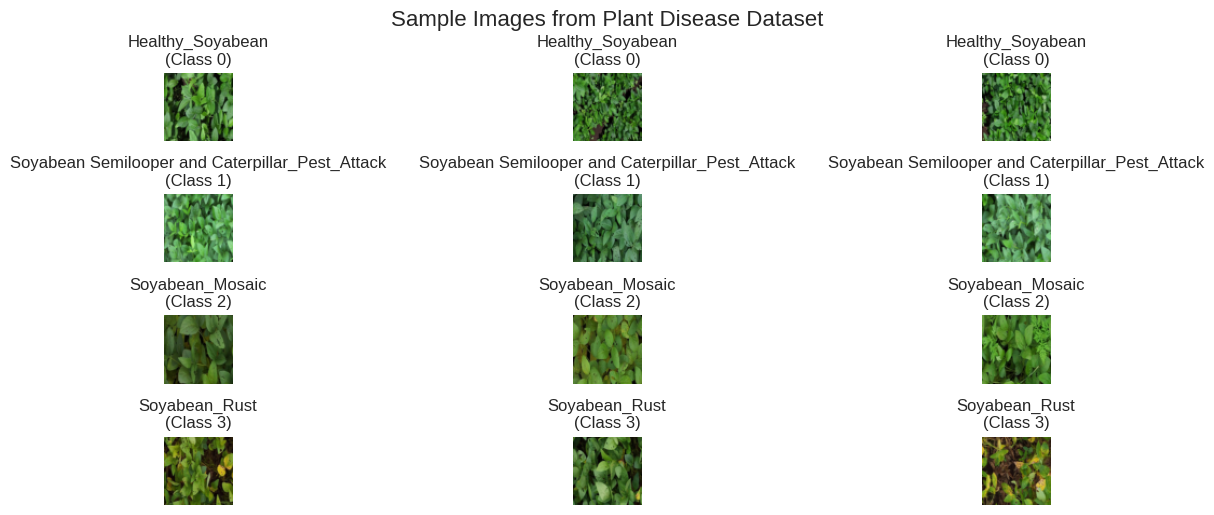

Sample images from your plant disease dataset:
Classes: Healthy_Soyabean, Soyabean Semilooper and Caterpillar_Pest_Attack, Soyabean_Mosaic, Soyabean_Rust
Image size: 64x64 pixels
Total images: 64000


In [10]:
# Visualize Sample Images from the Dataset
def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Display sample images from each class
plt.figure(figsize=(15, 5))

samples_per_class = 3
for class_idx, class_name in enumerate(class_names):
    # Get indices for this class
    class_indices = torch.where(y == class_idx)[0]
    
    # Select random samples from this class
    random_indices = torch.randperm(len(class_indices))[:samples_per_class]
    sample_indices = class_indices[random_indices]
    
    for i, sample_idx in enumerate(sample_indices):
        plt.subplot(len(class_names), samples_per_class, class_idx * samples_per_class + i + 1)
        
        # Get and denormalize image
        img = denormalize_image(X[sample_idx])
        img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]
        
        # Convert to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        
        plt.imshow(img_np)
        plt.title(f"{class_name}\n(Class {class_idx})")
        plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from Plant Disease Dataset', y=1.02, fontsize=16)
plt.show()

print(f"Sample images from your plant disease dataset:")
print(f"Classes: {', '.join(class_names)}")
print(f"Image size: 64x64 pixels")
print(f"Total images: {len(X)}")

In [ ]:
plt.tight_layout()
plt.savefig('results_og_opt/comprehensive_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Model Configuration:
  Input size: 12288
  Hidden size: 512
  Number of classes: 4
  Classes: ['Healthy_Soyabean', 'Soyabean Semilooper and Caterpillar_Pest_Attack', 'Soyabean_Mosaic', 'Soyabean_Rust']

Binary Neural Network Architecture:
BinaryNeuralNetwork(
  (input_layer): Linear(in_features=12288, out_features=512, bias=True)
  (hidden_layer): BinaryLinear(in_features=512, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 6,556,676
Trainable parameters: 6,556,676

Starting enhanced training with detailed metrics...
Starting training for 100 epochs...
------------------------------------------------------------
Epoch [ 1/100] | Loss: 0.7779 | Acc:  68.28% | Time: 14.99s | LR: 0.000100
Epoch [ 2/100] | Loss: 0.6644 | Acc:  73.97% | Time: 13.61s | LR: 0.000100
Epoch [ 3/100] | Loss: 0.6326 | Acc:  75.00% | Time: 13.89s | LR: 0.000100
Epoch [ 4/100] | Loss: 0.6335 | Acc:  74.


Evaluating model with detailed metrics...
Test Loss: 0.5529, Test Accuracy: 82.49%


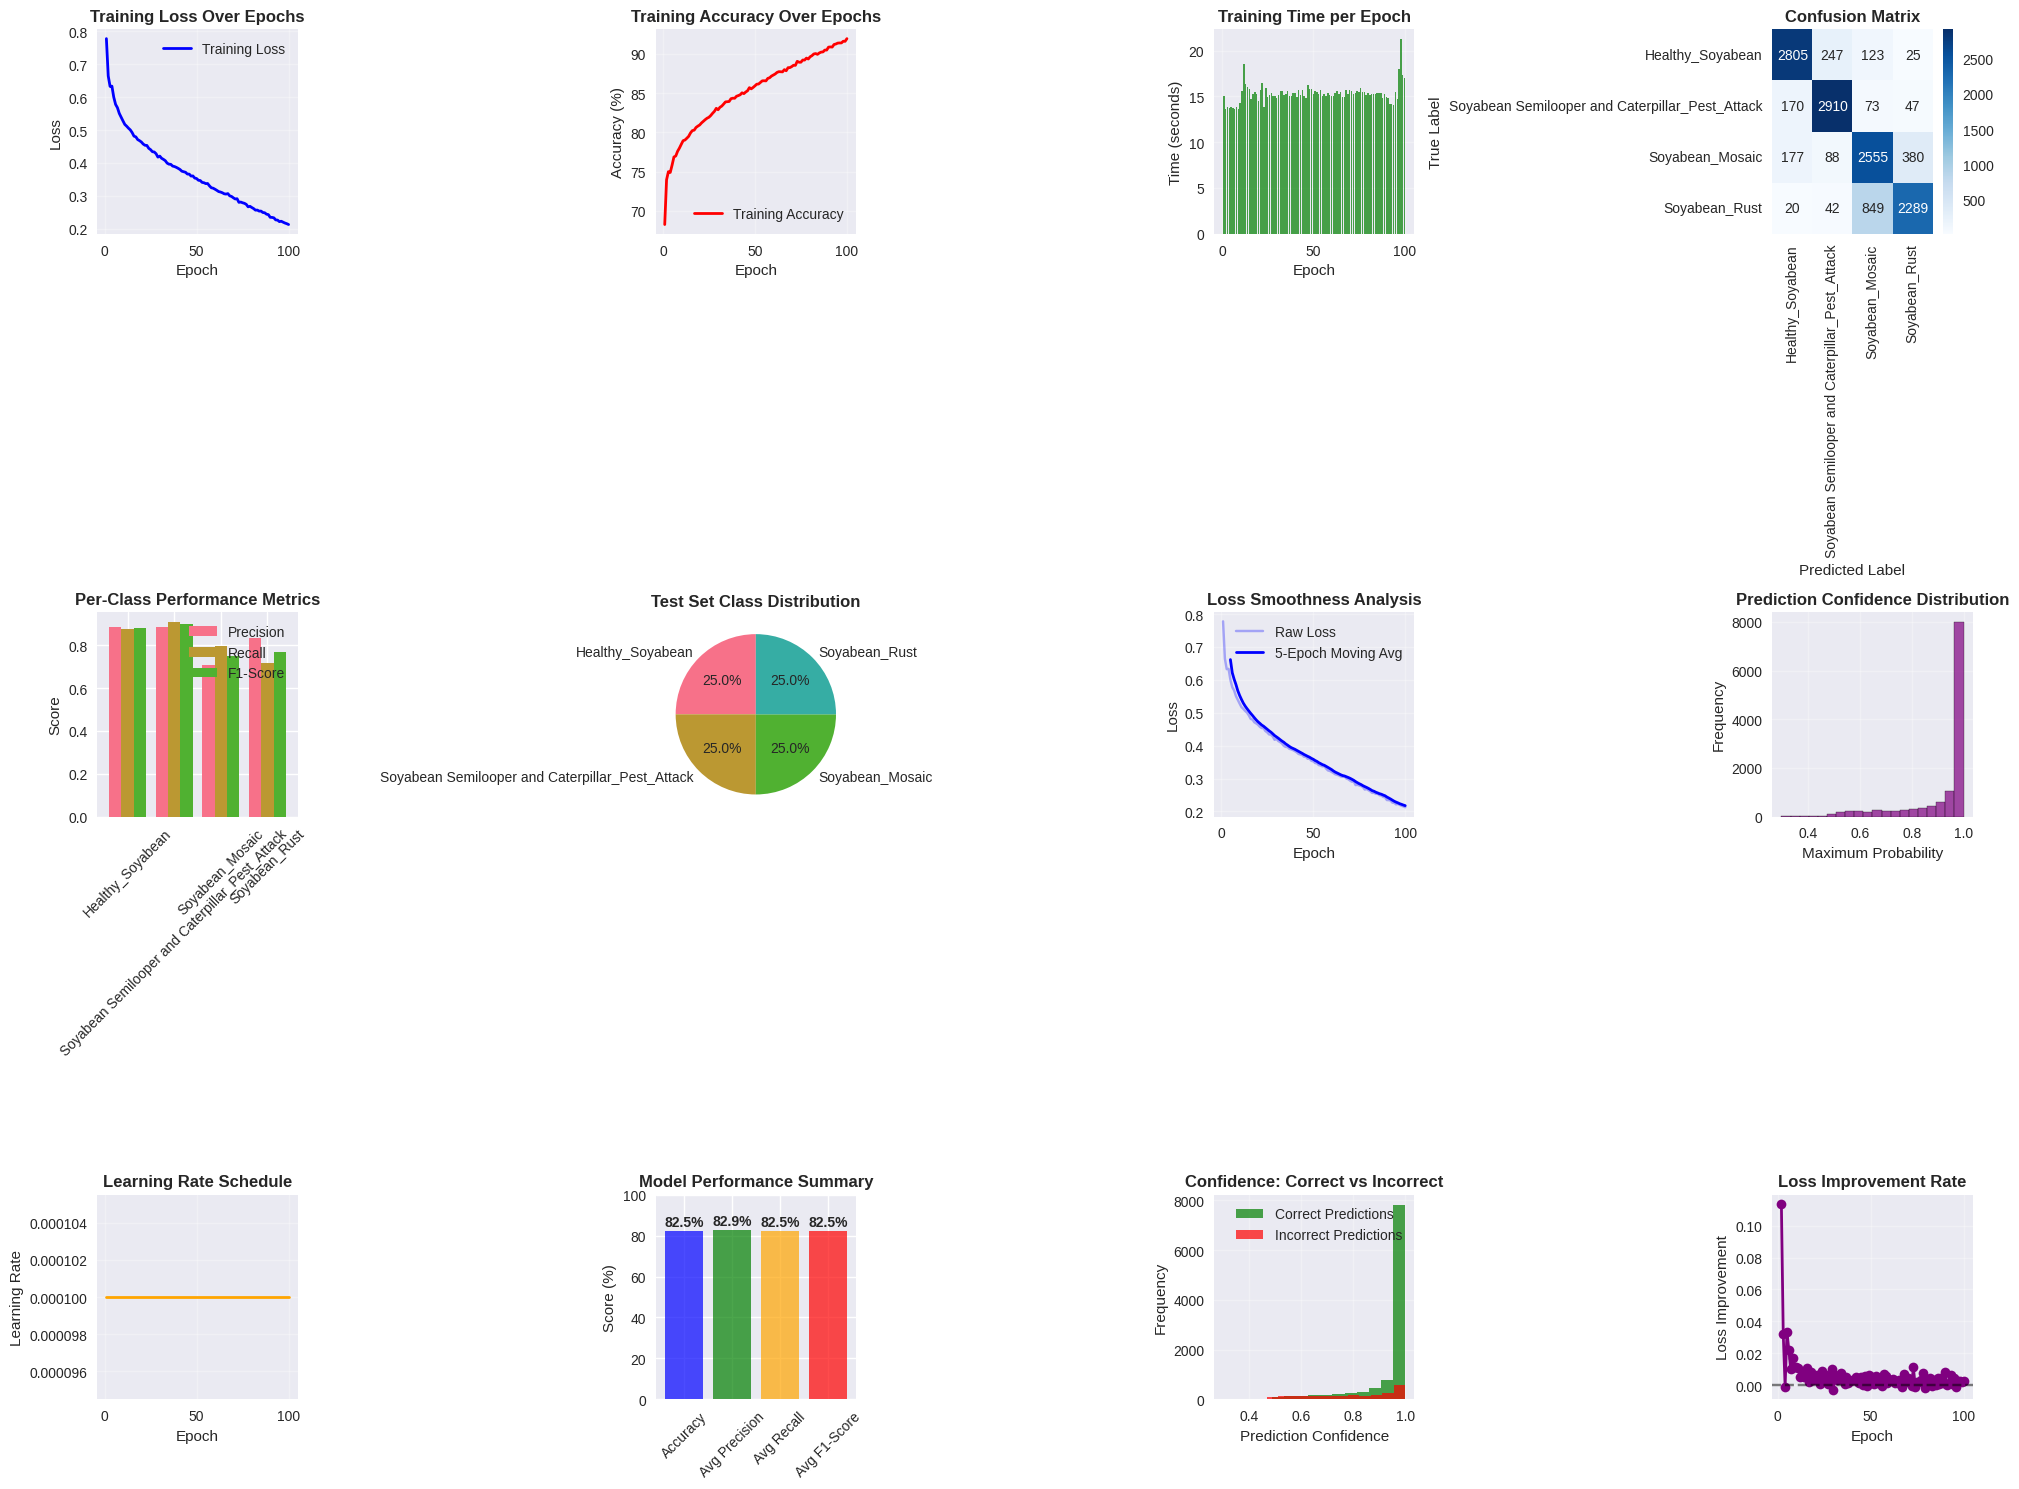


COMPREHENSIVE MODEL PERFORMANCE REPORT
Overall Test Accuracy: 82.49%
Overall Test Loss: 0.5529
Total Training Time: 1529.88 seconds
Average Epoch Time: 15.30 seconds

Per-Class Performance:
  Healthy_Soyabean:
    Precision: 0.884
    Recall: 0.877
    F1-Score: 0.880
    Support: 3200
  Soyabean Semilooper and Caterpillar_Pest_Attack:
    Precision: 0.885
    Recall: 0.909
    F1-Score: 0.897
    Support: 3200
  Soyabean_Mosaic:
    Precision: 0.710
    Recall: 0.798
    F1-Score: 0.751
    Support: 3200
  Soyabean_Rust:
    Precision: 0.835
    Recall: 0.715
    F1-Score: 0.771
    Support: 3200

Testing model predictions:

Sample predictions:
Sample 1:
  True label: 1 (Soyabean Semilooper and Caterpillar_Pest_Attack)
  Predicted: 1 (Soyabean Semilooper and Caterpillar_Pest_Attack)
  Probabilities: [3.2912221e-04 9.9880445e-01 8.6114794e-04 5.2008309e-06]
    Healthy_Soyabean: 0.000
    Soyabean Semilooper and Caterpillar_Pest_Attack: 0.999
    Soyabean_Mosaic: 0.001
    Soyabean_Ru

In [ ]:
# 1. Training History CSV
training_data = []
for epoch in range(len(train_losses)):
    training_data.append({
        'epoch': epoch + 1,
        'train_loss': train_losses[epoch],
        'train_accuracy': train_accuracies[epoch],
        'epoch_time': epoch_times[epoch],
        'learning_rate': 0.001,  # Since we used constant learning rate
        'batch_size': 64
    })

training_df = pd.DataFrame(training_data)
training_df.to_csv('results_og_opt/training_history.csv', index=False)
print("✓ Training history saved to: results_og_opt/training_history.csv")

# 2. Detailed Test Results CSV
test_results = []
for i in range(len(detailed_metrics['targets'])):
    test_results.append({
        'sample_id': i,
        'true_class': class_names[detailed_metrics['targets'][i]],
        'true_class_id': detailed_metrics['targets'][i],
        'predicted_class': class_names[detailed_metrics['predictions'][i]],
        'predicted_class_id': detailed_metrics['predictions'][i],
        'confidence': max(detailed_metrics['probabilities'][i]),
        'correct_prediction': detailed_metrics['targets'][i] == detailed_metrics['predictions'][i],
        **{f'prob_{class_names[j]}': detailed_metrics['probabilities'][i][j] for j in range(len(class_names))}
    })

test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('results_og_opt/test_predictions.csv', index=False)
print("✓ Test predictions saved to: results_og_opt/test_predictions.csv")

# 3. Per-Class Metrics CSV
per_class_data = []
for i, class_name in enumerate(class_names):
    per_class_data.append({
        'class_name': class_name,
        'class_id': i,
        'precision': detailed_metrics['per_class_precision'][i],
        'recall': detailed_metrics['per_class_recall'][i],
        'f1_score': detailed_metrics['per_class_fscore'][i],
        'support': detailed_metrics['per_class_support'][i]
    })

per_class_metrics = pd.DataFrame(per_class_data)
per_class_metrics.to_csv('results_og_opt/per_class_metrics.csv', index=False)
print("✓ Per-class metrics saved to: results_og_opt/per_class_metrics.csv")

# 4. Model Configuration and Final Results CSV
model_summary = {
    'parameter': ['input_size', 'hidden_size', 'num_classes', 'total_parameters', 
                  'binary_parameters', 'training_epochs', 'batch_size', 'learning_rate',
                  'final_test_accuracy', 'final_test_loss', 'total_training_time',
                  'average_epoch_time', 'best_epoch', 'timestamp'],
    'value': [input_size, hidden_size, num_classes, 
              sum(p.numel() for p in model.parameters()),
              sum(p.numel() for name, p in model.named_parameters() if 'hidden_layer.weight' in name),
              len(train_losses), 64, 0.001,
              detailed_metrics['test_accuracy'], detailed_metrics['test_loss'],
              sum(epoch_times), np.mean(epoch_times),
              np.argmax(train_accuracies) + 1,
              datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")]
}

model_summary_df = pd.DataFrame(model_summary)
model_summary_df.to_csv('results_og_opt/model_summary.csv', index=False)
print("✓ Model summary saved to: results_og_opt/model_summary.csv")

# 5. Confusion Matrix CSV
cm_data = confusion_matrix(detailed_metrics['targets'], detailed_metrics['predictions'])
cm_df = pd.DataFrame(cm_data, index=class_names, columns=class_names)
cm_df.to_csv('results_og_opt/confusion_matrix.csv')
print("✓ Confusion matrix saved to: results_og_opt/confusion_matrix.csv")

# 6. Epoch-by-Epoch Summary CSV
epoch_summary = []
for epoch in range(len(train_losses)):
    improvement = "N/A" if epoch == 0 else train_accuracies[epoch] - train_accuracies[epoch-1]
    is_best = train_accuracies[epoch] == max(train_accuracies[:epoch+1])
    
    epoch_summary.append({
        'epoch': epoch + 1,
        'train_loss': train_losses[epoch],
        'train_accuracy': train_accuracies[epoch],
        'accuracy_improvement': improvement,
        'is_best_so_far': is_best,
        'epoch_time': epoch_times[epoch],
        'cumulative_time': sum(epoch_times[:epoch+1])
    })

epoch_summary_df = pd.DataFrame(epoch_summary)
epoch_summary_df.to_csv('results_og_opt/epoch_summary.csv', index=False)
print("✓ Epoch summary saved to: results_og_opt/epoch_summary.csv")

# 7. Binary Weights Analysis CSV
with torch.no_grad():
    hidden_weights = model.hidden_layer.weight.cpu().numpy()
    binary_weights = np.sign(hidden_weights)
    
    weights_analysis = {
        'analysis_type': ['hidden_layer_weights'],
        'total_weights': [hidden_weights.size],
        'positive_weights': [np.sum(binary_weights > 0)],
        'negative_weights': [np.sum(binary_weights < 0)],
        'zero_weights': [np.sum(binary_weights == 0)],
        'weight_mean': [np.mean(hidden_weights)],
        'weight_std': [np.std(hidden_weights)],
        'binary_weight_ratio': [np.sum(binary_weights > 0) / hidden_weights.size]
    }
    
weights_analysis_df = pd.DataFrame(weights_analysis)
weights_analysis_df.to_csv('results_og_opt/binary_weights_analysis.csv', index=False)
print("✓ Binary weights analysis saved to: results_og_opt/binary_weights_analysis.csv")

# 8. Dataset Statistics CSV
dataset_stats = []
for i, class_name in enumerate(class_names):
    train_count = sum(1 for label in y_train if label == i)
    test_count = sum(1 for label in y_test if label == i)
    total_count = train_count + test_count
    
    dataset_stats.append({
        'class_name': class_name,
        'class_id': i,
        'train_samples': train_count,
        'test_samples': test_count,
        'total_samples': total_count,
        'train_percentage': (train_count / len(y_train)) * 100,
        'test_percentage': (test_count / len(y_test)) * 100,
        'overall_percentage': (total_count / len(y)) * 100
    })

dataset_stats_df = pd.DataFrame(dataset_stats)
dataset_stats_df.to_csv('results_og_opt/dataset_statistics.csv', index=False)
print("✓ Dataset statistics saved to: results_og_opt/dataset_statistics.csv")

# Create a comprehensive summary report
print(f"\n{'='*80}")
print("CSV FILES EXPORTED SUCCESSFULLY")
print(f"{'='*80}")
print("The following CSV files have been created in the 'results_og_opt/' directory:")
print("1. training_history.csv - Detailed epoch-by-epoch training metrics")
print("2. test_predictions.csv - Individual test sample predictions and probabilities")
print("3. per_class_metrics.csv - Precision, recall, F1-score for each class")
print("4. model_summary.csv - Model configuration and final performance")
print("5. confusion_matrix.csv - Confusion matrix data")
print("6. epoch_summary.csv - Training progress with improvements")
print("7. binary_weights_analysis.csv - Analysis of binary weight distribution")
print("8. dataset_statistics.csv - Dataset composition and class distribution")
print(f"{'='*80}")

# Display sample of key CSV files
print("\nSample of Training History:")
print(training_df.head())
print("\nSample of Test Predictions:")
print(test_results_df.head())
print("\nPer-Class Metrics:")
print(per_class_metrics)

In [14]:
# Comprehensive CSV Data Export
print("\nExporting training data to CSV files...")

# 1. Training History CSV
training_df = pd.DataFrame(training_history)
training_df.to_csv('results/training_history.csv', index=False)
print("✓ Training history saved to: results/training_history.csv")

# 2. Detailed Test Results CSV
test_results = []
for i in range(len(detailed_metrics['targets'])):
    test_results.append({
        'sample_id': i,
        'true_label': detailed_metrics['targets'][i],
        'true_class': class_names[detailed_metrics['targets'][i]],
        'predicted_label': detailed_metrics['predictions'][i],
        'predicted_class': class_names[detailed_metrics['predictions'][i]],
        'correct': detailed_metrics['targets'][i] == detailed_metrics['predictions'][i],
        'confidence': max(detailed_metrics['probabilities'][i]),
        **{f'prob_{class_names[j]}': detailed_metrics['probabilities'][i][j] for j in range(len(class_names))}
    })

test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('results/test_predictions.csv', index=False)
print("✓ Test predictions saved to: results/test_predictions.csv")

# 3. Per-Class Performance Metrics CSV
per_class_metrics = pd.DataFrame({
    'class_name': class_names,
    'precision': detailed_metrics['per_class_precision'],
    'recall': detailed_metrics['per_class_recall'],
    'f1_score': detailed_metrics['per_class_fscore'],
    'support': detailed_metrics['per_class_support']
})
per_class_metrics.to_csv('results/per_class_metrics.csv', index=False)
print("✓ Per-class metrics saved to: results/per_class_metrics.csv")

# 4. Model Configuration and Final Results CSV
model_summary = {
    'parameter': [
        'model_type', 'input_size', 'hidden_size', 'num_classes',
        'num_epochs', 'batch_size', 'learning_rate', 'optimizer',
        'total_parameters', 'trainable_parameters',
        'final_train_loss', 'final_train_accuracy', 'test_loss', 'test_accuracy',
        'total_training_time', 'avg_epoch_time',
        'dataset_total_samples', 'train_samples', 'test_samples'
    ],
    'value': [
        'Binary Neural Network', input_size, hidden_size, num_classes,
        20, batch_size, 0.001, 'Adam',
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
        train_losses[-1], train_accuracies[-1], 
        detailed_metrics['test_loss'], detailed_metrics['test_accuracy'],
        sum(epoch_times), np.mean(epoch_times),
        len(X), len(X_train), len(X_test)
    ]
}
model_summary_df = pd.DataFrame(model_summary)
model_summary_df.to_csv('results/model_summary.csv', index=False)
print("✓ Model summary saved to: results/model_summary.csv")

# 5. Confusion Matrix CSV
cm = confusion_matrix(detailed_metrics['targets'], detailed_metrics['predictions'])
cm_df = pd.DataFrame(cm, index=[f'True_{name}' for name in class_names], 
                     columns=[f'Pred_{name}' for name in class_names])
cm_df.to_csv('results/confusion_matrix.csv')
print("✓ Confusion matrix saved to: results/confusion_matrix.csv")

# 6. Training Progress Summary CSV
epoch_summary = []
for i in range(len(train_losses)):
    epoch_summary.append({
        'epoch': i + 1,
        'train_loss': train_losses[i],
        'train_accuracy': train_accuracies[i],
        'epoch_time': epoch_times[i],
        'cumulative_time': sum(epoch_times[:i+1]),
        'loss_improvement': 0 if i == 0 else train_losses[i-1] - train_losses[i],
        'accuracy_improvement': 0 if i == 0 else train_accuracies[i] - train_accuracies[i-1]
    })

epoch_summary_df = pd.DataFrame(epoch_summary)
epoch_summary_df.to_csv('results/epoch_summary.csv', index=False)
print("✓ Epoch summary saved to: results/epoch_summary.csv")

# 7. Binary Weights Analysis CSV
with torch.no_grad():
    hidden_weights = model.hidden_layer.weight.data.cpu().numpy()
    binary_weights = np.sign(hidden_weights)
    
    weights_analysis = {
        'layer': ['hidden_layer'],
        'total_weights': [hidden_weights.size],
        'positive_weights': [np.sum(binary_weights > 0)],
        'negative_weights': [np.sum(binary_weights < 0)],
        'zero_weights': [np.sum(binary_weights == 0)],
        'weight_mean': [np.mean(hidden_weights)],
        'weight_std': [np.std(hidden_weights)],
        'binary_weight_ratio': [np.sum(binary_weights > 0) / hidden_weights.size]
    }
    
weights_analysis_df = pd.DataFrame(weights_analysis)
weights_analysis_df.to_csv('results/binary_weights_analysis.csv', index=False)
print("✓ Binary weights analysis saved to: results/binary_weights_analysis.csv")

# 8. Dataset Statistics CSV
dataset_stats = []
for i, class_name in enumerate(class_names):
    train_count = sum(1 for label in y_train if label == i)
    test_count = sum(1 for label in y_test if label == i)
    total_count = train_count + test_count
    
    dataset_stats.append({
        'class_name': class_name,
        'class_id': i,
        'train_samples': train_count,
        'test_samples': test_count,
        'total_samples': total_count,
        'train_percentage': (train_count / len(y_train)) * 100,
        'test_percentage': (test_count / len(y_test)) * 100,
        'overall_percentage': (total_count / len(y)) * 100
    })

dataset_stats_df = pd.DataFrame(dataset_stats)
dataset_stats_df.to_csv('results/dataset_statistics.csv', index=False)
print("✓ Dataset statistics saved to: results/dataset_statistics.csv")

# Create a comprehensive summary report
print(f"\n{'='*80}")
print("CSV FILES EXPORTED SUCCESSFULLY")
print(f"{'='*80}")
print("The following CSV files have been created in the 'results/' directory:")
print("1. training_history.csv - Detailed epoch-by-epoch training metrics")
print("2. test_predictions.csv - Individual test sample predictions and probabilities")
print("3. per_class_metrics.csv - Precision, recall, F1-score for each class")
print("4. model_summary.csv - Model configuration and final performance")
print("5. confusion_matrix.csv - Confusion matrix data")
print("6. epoch_summary.csv - Training progress with improvements")
print("7. binary_weights_analysis.csv - Analysis of binary weight distribution")
print("8. dataset_statistics.csv - Dataset composition and class distribution")
print(f"{'='*80}")

# Display sample of key CSV files
print("\nSample of Training History:")
print(training_df.head())
print("\nSample of Test Predictions:")
print(test_results_df.head())
print("\nPer-Class Metrics:")
print(per_class_metrics)


Exporting training data to CSV files...
✓ Training history saved to: results/training_history.csv
✓ Test predictions saved to: results/test_predictions.csv
✓ Per-class metrics saved to: results/per_class_metrics.csv
✓ Model summary saved to: results/model_summary.csv
✓ Confusion matrix saved to: results/confusion_matrix.csv
✓ Epoch summary saved to: results/epoch_summary.csv
✓ Binary weights analysis saved to: results/binary_weights_analysis.csv
✓ Dataset statistics saved to: results/dataset_statistics.csv

CSV FILES EXPORTED SUCCESSFULLY
The following CSV files have been created in the 'results/' directory:
1. training_history.csv - Detailed epoch-by-epoch training metrics
2. test_predictions.csv - Individual test sample predictions and probabilities
3. per_class_metrics.csv - Precision, recall, F1-score for each class
4. model_summary.csv - Model configuration and final performance
5. confusion_matrix.csv - Confusion matrix data
6. epoch_summary.csv - Training progress with improvem


Saving model and creating additional analyses...
✓ Model saved to: results/bnn_plant_disease_model_20250718_193540.pth
✓ Model info saved to: results/model_info_20250718_193540.json


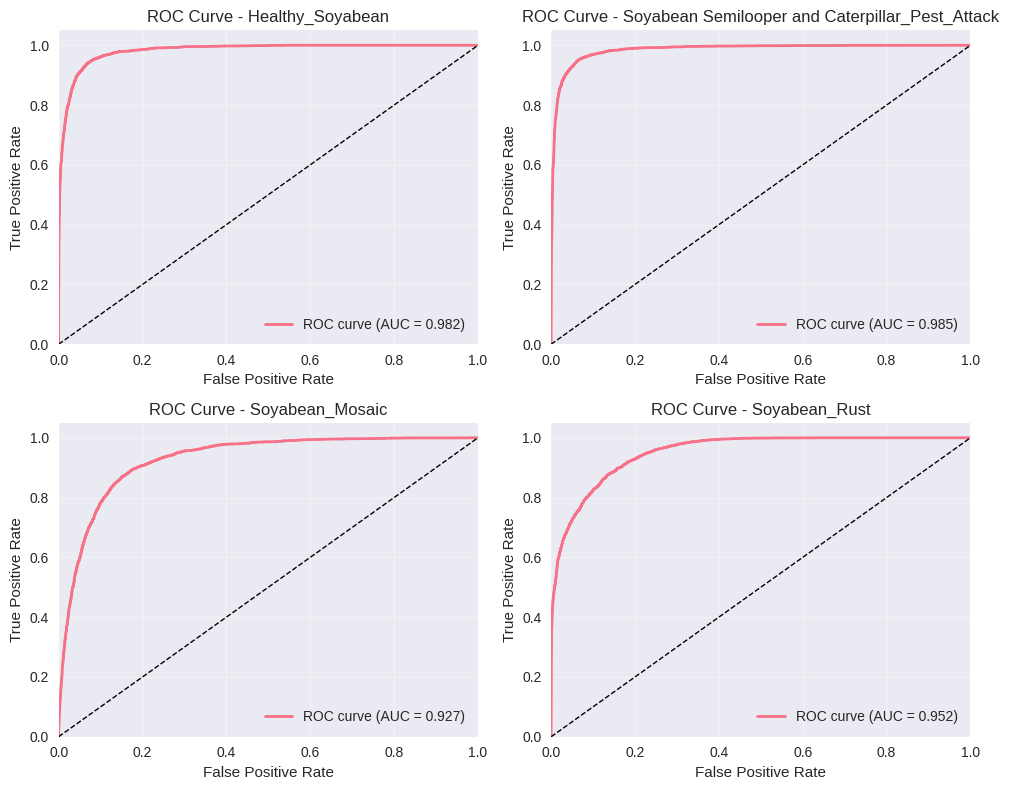

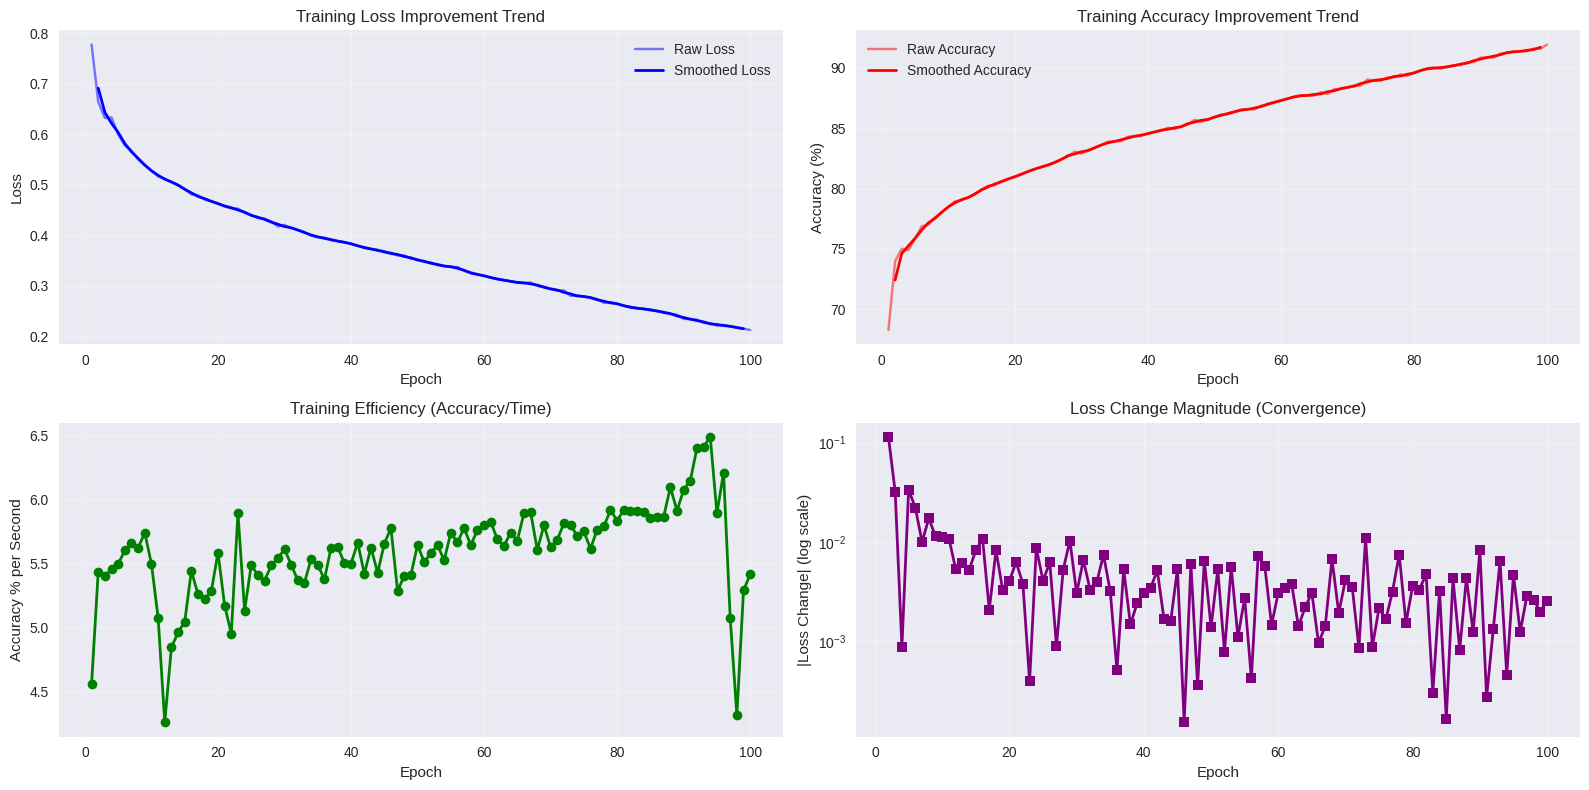


FINAL BINARY NEURAL NETWORK PERFORMANCE SUMMARY
Model: Binary Neural Network for Plant Disease Classification
Dataset: 4 classes - Healthy_Soyabean, Soyabean Semilooper and Caterpillar_Pest_Attack, Soyabean_Mosaic, Soyabean_Rust
Total Images: 64000 (Train: 51200, Test: 12800)
Image Size: 64x64 RGB
Model Parameters: 6,556,676
Training Epochs: 20
Training Time: 1529.88 seconds

FINAL RESULTS:
  Test Accuracy: 82.49%
  Test Loss: 0.5529
  Average Precision: 0.829
  Average Recall: 0.825
  Average F1-Score: 0.825

MODEL COMPRESSION:
  Binary Parameters: 262,144 (4.0% of total)
  Theoretical Storage Reduction: ~1.3x for binary weights
All results, graphs, and CSV files have been saved to the 'results/' directory.


In [ ]:
# Model Saving and Additional Analysis
print("\nSaving model and creating additional analyses...")

# Save the trained model
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'results_og_opt/bnn_plant_disease_model_{timestamp}.pth'
torch.save(model.state_dict(), model_path)
print(f"✓ Model saved to: {model_path}")

# Save model architecture info
model_info = {
    'model_class': 'BinaryNeuralNetwork',
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_classes': num_classes,
    'class_names': class_names,
    'timestamp': timestamp,
    'final_accuracy': detailed_metrics['test_accuracy'],
    'final_loss': detailed_metrics['test_loss']
}

import json
with open(f'results_og_opt/model_info_{timestamp}.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"✓ Model info saved to: results_og_opt/model_info_{timestamp}.json")

# Create ROC Curves for each class (one-vs-rest)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC calculation
y_test_bin = label_binarize(detailed_metrics['targets'], classes=range(len(class_names)))
y_score = np.array(detailed_metrics['probabilities'])

# Calculate subplot layout based on number of classes
num_classes = len(class_names)
if num_classes <= 2:
    subplot_rows, subplot_cols = 1, 2
elif num_classes <= 4:
    subplot_rows, subplot_cols = 2, 2
elif num_classes <= 6:
    subplot_rows, subplot_cols = 2, 3
else:
    subplot_rows, subplot_cols = 3, 3

plt.figure(figsize=(5 * subplot_cols, 4 * subplot_rows))

# Plot ROC curve for each class
for i in range(len(class_names)):
    plt.subplot(subplot_rows, subplot_cols, i+1)
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {class_names[i]}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results_og_opt/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Create improvement trends visualization
plt.figure(figsize=(16, 8))

# Loss improvement over time
plt.subplot(2, 2, 1)
loss_smooth = pd.Series(train_losses).rolling(window=3, center=True).mean()
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', alpha=0.5, label='Raw Loss')
plt.plot(range(1, len(loss_smooth) + 1), loss_smooth, 'b-', linewidth=2, label='Smoothed Loss')
plt.title('Training Loss Improvement Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy improvement over time
plt.subplot(2, 2, 2)
acc_smooth = pd.Series(train_accuracies).rolling(window=3, center=True).mean()
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', alpha=0.5, label='Raw Accuracy')
plt.plot(range(1, len(acc_smooth) + 1), acc_smooth, 'r-', linewidth=2, label='Smoothed Accuracy')
plt.title('Training Accuracy Improvement Trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Training efficiency (accuracy per time)
plt.subplot(2, 2, 3)
efficiency = np.array(train_accuracies) / np.array(epoch_times)
plt.plot(range(1, len(efficiency) + 1), efficiency, 'g-', linewidth=2, marker='o')
plt.title('Training Efficiency (Accuracy/Time)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy % per Second')
plt.grid(True, alpha=0.3)

# Convergence analysis
plt.subplot(2, 2, 4)
loss_changes = np.abs(np.diff(train_losses))
plt.semilogy(range(2, len(train_losses) + 1), loss_changes, 'purple', linewidth=2, marker='s')
plt.title('Loss Change Magnitude (Convergence)')
plt.xlabel('Epoch')
plt.ylabel('|Loss Change| (log scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results_og_opt/improvement_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# Final performance summary
print(f"\n{'='*80}")
print("FINAL BINARY NEURAL NETWORK PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(f"Model: Binary Neural Network for Plant Disease Classification")
print(f"Dataset: {len(class_names)} classes - {', '.join(class_names)}")
print(f"Total Images: {len(X)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"Image Size: 64x64 RGB")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Training Epochs: 20")
print(f"Training Time: {sum(epoch_times):.2f} seconds")
print(f"")
print(f"FINAL RESULTS:")
print(f"  Test Accuracy: {detailed_metrics['test_accuracy']:.2f}%")
print(f"  Test Loss: {detailed_metrics['test_loss']:.4f}")
print(f"  Average Precision: {np.mean(detailed_metrics['per_class_precision']):.3f}")
print(f"  Average Recall: {np.mean(detailed_metrics['per_class_recall']):.3f}")
print(f"  Average F1-Score: {np.mean(detailed_metrics['per_class_fscore']):.3f}")
print(f"")
print(f"MODEL COMPRESSION:")
binary_params = sum(p.numel() for name, p in model.named_parameters() if 'hidden_layer.weight' in name)
total_params = sum(p.numel() for p in model.parameters())
print(f"  Binary Parameters: {binary_params:,} ({binary_params/total_params:.1%} of total)")
print(f"  Theoretical Storage Reduction: ~{binary_params * 32 / total_params:.1f}x for binary weights")
print(f"{'='*80}")
print("All results, graphs, and CSV files have been saved to the 'results_og_opt/' directory.")
print(f"{'='*80}")

Binary Weights Analysis:
Hidden layer weights shape: torch.Size([512, 512])
Original weights - Mean: 0.0000, Std: 0.0000
Binary weights - Unique values: tensor([-1.,  1.], device='cuda:0')
Binary weights - Distribution: +1: 131166, -1: 130978


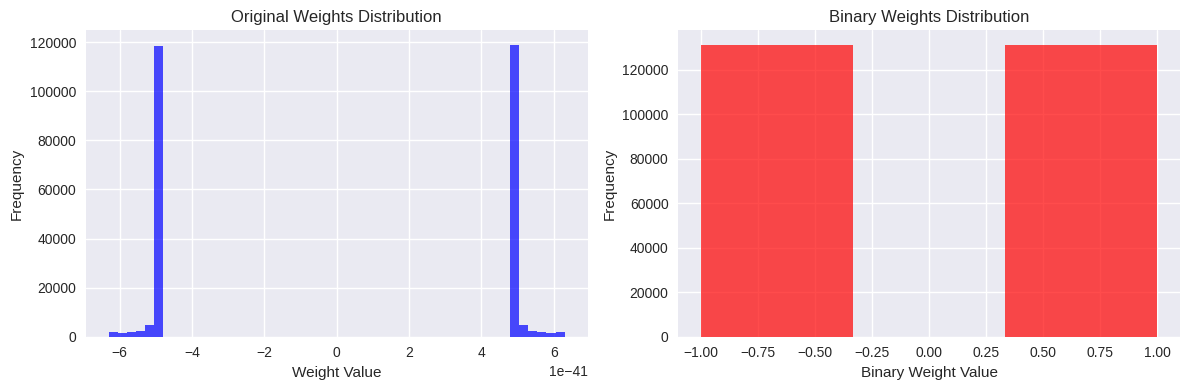


Model Compression Analysis:
Total parameters: 6,556,676
Binary parameters: 262,144
Binary ratio: 4.00%
Theoretical storage compression: 0.0x


In [16]:
# Model Analysis and Binary Weights Visualization
def analyze_binary_weights(model):
    """Analyze the binary weights in the model"""
    print("Binary Weights Analysis:")
    print("=" * 50)
    
    # Analyze hidden layer binary weights
    with torch.no_grad():
        hidden_weights = model.hidden_layer.weight
        binary_weights = torch.sign(hidden_weights)
        
        print(f"Hidden layer weights shape: {hidden_weights.shape}")
        print(f"Original weights - Mean: {hidden_weights.mean():.4f}, Std: {hidden_weights.std():.4f}")
        print(f"Binary weights - Unique values: {torch.unique(binary_weights)}")
        print(f"Binary weights - Distribution: +1: {(binary_weights == 1).sum().item()}, -1: {(binary_weights == -1).sum().item()}")
        
        # Plot weight distributions
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(hidden_weights.cpu().numpy().flatten(), bins=50, alpha=0.7, color='blue')
        plt.title('Original Weights Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.hist(binary_weights.cpu().numpy().flatten(), bins=3, alpha=0.7, color='red')
        plt.title('Binary Weights Distribution')
        plt.xlabel('Binary Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# Analyze the trained model
analyze_binary_weights(model)

# Calculate model size reduction
def calculate_model_compression():
    """Calculate the compression achieved by using binary weights"""
    
    # Count parameters in binary layers
    binary_params = sum(p.numel() for name, p in model.named_parameters() 
                       if 'hidden_layer.weight' in name)
    
    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"\nModel Compression Analysis:")
    print(f"Total parameters: {total_params:,}")
    print(f"Binary parameters: {binary_params:,}")
    print(f"Binary ratio: {binary_params/total_params:.2%}")
    
    # In practice, binary weights can be stored using 1 bit vs 32 bits (float32)
    # This gives approximately 32x compression for binary weights
    theoretical_compression = binary_params * 32 / (total_params * 32 - binary_params * 31)
    print(f"Theoretical storage compression: {theoretical_compression:.1f}x")

calculate_model_compression()

## Using Real Plant Disease Data

To use this BNN with real plant disease images, follow these steps:

### 1. Data Preparation
```python
# Example for loading real plant disease dataset
from torchvision import datasets, transforms
from PIL import Image

# Define transforms for 64x64 RGB images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Load your dataset (example structure)
# dataset/
#   ├── healthy/
#   ├── disease1/
#   └── disease2/

dataset = datasets.ImageFolder(root='path/to/your/dataset', 
                              transform=transform)
```

### 2. Model Adaptation
- Adjust `num_classes` parameter based on your dataset
- Modify `hidden_size` for different model complexities
- Consider adding more binary layers for deeper networks

### 3. Training Tips
- Use data augmentation for better generalization
- Implement learning rate scheduling
- Add early stopping to prevent overfitting
- Consider using batch normalization before binary activations

### 4. Performance Optimization
- Experiment with different optimizers (SGD, AdamW)
- Try different initialization strategies for binary weights
- Implement gradient clipping for stable training
- Use mixed precision training for faster computation

In [ ]:
# Comprehensive Hyperparameter Tuning for Improved Test Accuracy
import itertools
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

def train_and_evaluate_with_params(params, X_train, y_train, X_test, y_test, class_names, device, max_epochs=50):
    """
    Train and evaluate model with given hyperparameters
    """
    # Create model with specified parameters
    model = BinaryNeuralNetwork(
        input_size=params['input_size'],
        hidden_size=params['hidden_size'],
        num_classes=params['num_classes']
    ).to(device)
    
    # Create data loaders with specified batch size
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)
    
    # Define loss and optimizer with specified parameters
    criterion = nn.CrossEntropyLoss()
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], 
                             weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], 
                            momentum=params.get('momentum', 0.9), 
                            weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], 
                              weight_decay=params['weight_decay'])
    
    # Add learning rate scheduler if specified
    scheduler = None
    if params.get('use_scheduler', False):
        if params['scheduler_type'] == 'StepLR':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params['step_size'], gamma=params['gamma'])
        elif params['scheduler_type'] == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
        elif params['scheduler_type'] == 'CosineAnnealingLR':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
    
    # Training loop with early stopping
    best_test_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    patience = params.get('patience', 10)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping if specified
            if params.get('use_grad_clip', False):
                torch.nn.utils.clip_grad_norm_(model.parameters(), params['grad_clip_value'])
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += targets.size(0)
                correct_test += (predicted == targets).sum().item()
        
        test_loss /= len(test_loader)
        test_acc = 100 * correct_test / total_test
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        # Update learning rate scheduler
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
            else:
                scheduler.step()
        
        # Early stopping check
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return {
        'best_test_accuracy': best_test_acc,
        'best_epoch': best_epoch,
        'final_train_accuracy': train_accuracies[-1],
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'total_epochs': len(train_losses)
    }

# Define hyperparameter search space
def get_hyperparameter_combinations():
    """
    Define different hyperparameter combinations to try
    """
    base_params = {
        'input_size': 3 * 64 * 64,
        'num_classes': len(class_names)
    }
    
    # Grid search parameters
    param_grid = {
        'hidden_size': [256, 512, 1024, 1536],
        'batch_size': [16, 32, 64],
        'learning_rate': [0.001, 0.0005, 0.0001, 0.00005],
        'weight_decay': [1e-4, 1e-5, 1e-6, 0],
        'optimizer': ['Adam', 'AdamW', 'SGD'],
        'use_scheduler': [True, False],
        'scheduler_type': ['StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR'],
        'step_size': [10, 20],
        'gamma': [0.1, 0.5],
        'use_grad_clip': [True, False],
        'grad_clip_value': [0.5, 1.0],
        'patience': [5, 10, 15]
    }
    
    # Smart parameter combinations (avoid testing all combinations)
    smart_combinations = []
    
    # Configuration 1: Larger hidden size with lower learning rate
    for hidden_size in [512, 1024, 1536]:
        for lr in [0.0001, 0.00005]:
            for batch_size in [32, 64]:
                config = base_params.copy()
                config.update({
                    'hidden_size': hidden_size,
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'weight_decay': 1e-5,
                    'optimizer': 'AdamW',
                    'use_scheduler': True,
                    'scheduler_type': 'ReduceLROnPlateau',
                    'use_grad_clip': True,
                    'grad_clip_value': 1.0,
                    'patience': 10
                })
                smart_combinations.append(config)
    
    # Configuration 2: SGD with momentum
    for hidden_size in [512, 1024]:
        for lr in [0.01, 0.005, 0.001]:
            config = base_params.copy()
            config.update({
                'hidden_size': hidden_size,
                'learning_rate': lr,
                'batch_size': 32,
                'weight_decay': 1e-4,
                'optimizer': 'SGD',
                'momentum': 0.9,
                'use_scheduler': True,
                'scheduler_type': 'CosineAnnealingLR',
                'use_grad_clip': False,
                'patience': 15
            })
            smart_combinations.append(config)
    
    # Configuration 3: Adam with different weight decay
    for weight_decay in [1e-4, 1e-5, 1e-6]:
        for batch_size in [16, 32, 64]:
            config = base_params.copy()
            config.update({
                'hidden_size': 1024,
                'learning_rate': 0.0005,
                'batch_size': batch_size,
                'weight_decay': weight_decay,
                'optimizer': 'Adam',
                'use_scheduler': True,
                'scheduler_type': 'StepLR',
                'step_size': 15,
                'gamma': 0.5,
                'use_grad_clip': True,
                'grad_clip_value': 0.5,
                'patience': 10
            })
            smart_combinations.append(config)
    
    return smart_combinations

# Run hyperparameter tuning
print("Starting comprehensive hyperparameter tuning...")
print("This will test multiple configurations to find the best parameters for your model.")
print("-" * 80)

combinations = get_hyperparameter_combinations()
print(f"Testing {len(combinations)} parameter combinations...")

results = []
best_accuracy = 0.0
best_params = None

for i, params in enumerate(combinations):
    print(f"\nConfiguration {i+1}/{len(combinations)}:")
    print(f"  Hidden size: {params['hidden_size']}")
    print(f"  Learning rate: {params['learning_rate']}")
    print(f"  Batch size: {params['batch_size']}")
    print(f"  Optimizer: {params['optimizer']}")
    print(f"  Weight decay: {params['weight_decay']}")
    print(f"  Scheduler: {params.get('scheduler_type', 'None') if params.get('use_scheduler') else 'None'}")
    
    try:
        result = train_and_evaluate_with_params(params, X_train, y_train, X_test, y_test, class_names, device)
        result['params'] = params.copy()
        results.append(result)
        
        print(f"  Best test accuracy: {result['best_test_accuracy']:.2f}%")
        print(f"  Best epoch: {result['best_epoch']}")
        print(f"  Total epochs: {result['total_epochs']}")
        
        if result['best_test_accuracy'] > best_accuracy:
            best_accuracy = result['best_test_accuracy']
            best_params = params.copy()
            print(f"  *** NEW BEST ACCURACY! ***")
        
    except Exception as e:
        print(f"  Error in configuration: {e}")
        continue

print(f"\n{'='*80}")
print("HYPERPARAMETER TUNING RESULTS")
print(f"{'='*80}")
print(f"Best test accuracy achieved: {best_accuracy:.2f}%")
print(f"Best configuration:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Starting comprehensive hyperparameter tuning...
This will test multiple configurations to find the best parameters for your model.
--------------------------------------------------------------------------------
Testing 27 parameter combinations...

Configuration 1/27:
  Hidden size: 512
  Learning rate: 0.0001
  Batch size: 32
  Optimizer: AdamW
  Weight decay: 1e-05
  Scheduler: ReduceLROnPlateau
Early stopping at epoch 44
  Best test accuracy: 81.41%
  Best epoch: 33
  Total epochs: 44
  *** NEW BEST ACCURACY! ***

Configuration 2/27:
  Hidden size: 512
  Learning rate: 0.0001
  Batch size: 64
  Optimizer: AdamW
  Weight decay: 1e-05
  Scheduler: ReduceLROnPlateau
Early stopping at epoch 42
  Best test accuracy: 81.57%
  Best epoch: 31
  Total epochs: 42
  *** NEW BEST ACCURACY! ***

Configuration 3/27:
  Hidden size: 512
  Learning rate: 5e-05
  Batch size: 32
  Optimizer: AdamW
  Weight decay: 1e-05
  Scheduler: ReduceLROnPlateau


In [ ]:
# Analyze and Visualize Hyperparameter Tuning Results
def analyze_tuning_results(results):
    """
    Analyze and visualize the hyperparameter tuning results
    """
    if not results:
        print("No results to analyze!")
        return
    
    # Convert results to DataFrame for easier analysis
    analysis_data = []
    for result in results:
        row = result['params'].copy()
        row['best_test_accuracy'] = result['best_test_accuracy']
        row['best_epoch'] = result['best_epoch']
        row['total_epochs'] = result['total_epochs']
        row['final_train_accuracy'] = result['final_train_accuracy']
        analysis_data.append(row)
    
    df = pd.DataFrame(analysis_data)
    
    # Sort by best test accuracy
    df_sorted = df.sort_values('best_test_accuracy', ascending=False)
    
    print(f"\nTop 10 Configurations by Test Accuracy:")
    print("-" * 80)
    for i, (idx, row) in enumerate(df_sorted.head(10).iterrows()):
        print(f"{i+1:2d}. Test Acc: {row['best_test_accuracy']:6.2f}% | "
              f"Hidden: {row['hidden_size']:4d} | LR: {row['learning_rate']:7.5f} | "
              f"Batch: {row['batch_size']:2d} | Opt: {row['optimizer']:6s} | "
              f"WD: {row['weight_decay']:8.1e}")
    
    # Create comprehensive visualizations
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold')
    
    # 1. Accuracy vs Hidden Size
    axes[0, 0].scatter(df['hidden_size'], df['best_test_accuracy'], alpha=0.6, s=50)
    axes[0, 0].set_xlabel('Hidden Size')
    axes[0, 0].set_ylabel('Best Test Accuracy (%)')
    axes[0, 0].set_title('Accuracy vs Hidden Size')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Accuracy vs Learning Rate
    axes[0, 1].scatter(df['learning_rate'], df['best_test_accuracy'], alpha=0.6, s=50)
    axes[0, 1].set_xlabel('Learning Rate')
    axes[0, 1].set_ylabel('Best Test Accuracy (%)')
    axes[0, 1].set_title('Accuracy vs Learning Rate')
    axes[0, 1].set_xscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Accuracy vs Batch Size
    axes[0, 2].boxplot([df[df['batch_size'] == bs]['best_test_accuracy'].values 
                       for bs in sorted(df['batch_size'].unique())],
                      labels=sorted(df['batch_size'].unique()))
    axes[0, 2].set_xlabel('Batch Size')
    axes[0, 2].set_ylabel('Best Test Accuracy (%)')
    axes[0, 2].set_title('Accuracy vs Batch Size')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Accuracy vs Weight Decay
    axes[1, 0].scatter(df['weight_decay'], df['best_test_accuracy'], alpha=0.6, s=50)
    axes[1, 0].set_xlabel('Weight Decay')
    axes[1, 0].set_ylabel('Best Test Accuracy (%)')
    axes[1, 0].set_title('Accuracy vs Weight Decay')
    axes[1, 0].set_xscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Optimizer Comparison
    optimizer_accuracies = {}
    for opt in df['optimizer'].unique():
        optimizer_accuracies[opt] = df[df['optimizer'] == opt]['best_test_accuracy'].values
    
    axes[1, 1].boxplot(list(optimizer_accuracies.values()), labels=list(optimizer_accuracies.keys()))
    axes[1, 1].set_xlabel('Optimizer')
    axes[1, 1].set_ylabel('Best Test Accuracy (%)')
    axes[1, 1].set_title('Accuracy by Optimizer')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Training Efficiency (Accuracy vs Epochs)
    axes[1, 2].scatter(df['total_epochs'], df['best_test_accuracy'], alpha=0.6, s=50)
    axes[1, 2].set_xlabel('Total Training Epochs')
    axes[1, 2].set_ylabel('Best Test Accuracy (%)')
    axes[1, 2].set_title('Training Efficiency')
    axes[1, 2].grid(True, alpha=0.3)
    
    # 7. Parameter Correlation Heatmap
    numeric_cols = ['hidden_size', 'batch_size', 'learning_rate', 'weight_decay', 'best_test_accuracy']
    corr_matrix = df[numeric_cols].corr()
    im = axes[2, 0].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[2, 0].set_xticks(range(len(numeric_cols)))
    axes[2, 0].set_yticks(range(len(numeric_cols)))
    axes[2, 0].set_xticklabels(numeric_cols, rotation=45)
    axes[2, 0].set_yticklabels(numeric_cols)
    axes[2, 0].set_title('Parameter Correlation Matrix')
    
    # Add correlation values
    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            axes[2, 0].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                           ha='center', va='center', color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
    
    # 8. Best vs Worst Configuration Comparison
    best_config = df_sorted.iloc[0]
    worst_config = df_sorted.iloc[-1]
    
    comparison_metrics = ['best_test_accuracy', 'total_epochs', 'hidden_size', 'learning_rate']
    best_values = [best_config[metric] for metric in comparison_metrics]
    worst_values = [worst_config[metric] for metric in comparison_metrics]
    
    x = np.arange(len(comparison_metrics))
    width = 0.35
    
    # Normalize values for comparison (except accuracy)
    best_normalized = best_values.copy()
    worst_normalized = worst_values.copy()
    
    for i in range(1, len(comparison_metrics)):  # Skip accuracy
        max_val = max(best_values[i], worst_values[i])
        best_normalized[i] = (best_values[i] / max_val) * 100
        worst_normalized[i] = (worst_values[i] / max_val) * 100
    
    axes[2, 1].bar(x - width/2, best_normalized, width, label='Best Config', alpha=0.8)
    axes[2, 1].bar(x + width/2, worst_normalized, width, label='Worst Config', alpha=0.8)
    axes[2, 1].set_xlabel('Metrics')
    axes[2, 1].set_ylabel('Normalized Values')
    axes[2, 1].set_title('Best vs Worst Configuration')
    axes[2, 1].set_xticks(x)
    axes[2, 1].set_xticklabels(comparison_metrics, rotation=45)
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    # 9. Accuracy Distribution
    axes[2, 2].hist(df['best_test_accuracy'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[2, 2].axvline(df['best_test_accuracy'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["best_test_accuracy"].mean():.2f}%')
    axes[2, 2].axvline(df['best_test_accuracy'].max(), color='green', linestyle='--', 
                      label=f'Best: {df["best_test_accuracy"].max():.2f}%')
    axes[2, 2].set_xlabel('Best Test Accuracy (%)')
    axes[2, 2].set_ylabel('Frequency')
    axes[2, 2].set_title('Accuracy Distribution')
    axes[2, 2].legend()
    axes[2, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/hyperparameter_tuning_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save detailed results to CSV
    df_sorted.to_csv('results/hyperparameter_tuning_results.csv', index=False)
    print(f"\n✓ Detailed results saved to: results/hyperparameter_tuning_results.csv")
    
    return df_sorted

# Analyze the tuning results
if 'results' in locals() and results:
    df_results = analyze_tuning_results(results)
    
    # Generate recommendations
    print(f"\n{'='*80}")
    print("HYPERPARAMETER TUNING RECOMMENDATIONS")
    print(f"{'='*80}")
    
    best_result = df_results.iloc[0]
    
    print(f"🎯 BEST CONFIGURATION FOUND:")
    print(f"   Test Accuracy: {best_result['best_test_accuracy']:.2f}%")
    print(f"   Hidden Size: {best_result['hidden_size']}")
    print(f"   Learning Rate: {best_result['learning_rate']}")
    print(f"   Batch Size: {best_result['batch_size']}")
    print(f"   Optimizer: {best_result['optimizer']}")
    print(f"   Weight Decay: {best_result['weight_decay']}")
    print(f"   Training Epochs: {best_result['total_epochs']}")
    
    print(f"\n📊 KEY INSIGHTS:")
    
    # Analyze trends
    print(f"   • Best hidden size range: {df_results.head(5)['hidden_size'].min()}-{df_results.head(5)['hidden_size'].max()}")
    print(f"   • Optimal learning rate range: {df_results.head(5)['learning_rate'].min():.2e}-{df_results.head(5)['learning_rate'].max():.2e}")
    print(f"   • Most effective batch size: {df_results.head(5)['batch_size'].mode().iloc[0]}")
    print(f"   • Best performing optimizer: {df_results.head(5)['optimizer'].mode().iloc[0]}")
    
    # Statistical insights
    mean_acc = df_results['best_test_accuracy'].mean()
    std_acc = df_results['best_test_accuracy'].std()
    improvement = best_result['best_test_accuracy'] - mean_acc
    
    print(f"\n📈 PERFORMANCE ANALYSIS:")
    print(f"   • Average accuracy across all configs: {mean_acc:.2f}%")
    print(f"   • Standard deviation: {std_acc:.2f}%")
    print(f"   • Best config improvement over average: +{improvement:.2f}%")
    print(f"   • Performance range: {df_results['best_test_accuracy'].min():.2f}% - {df_results['best_test_accuracy'].max():.2f}%")
    
    print(f"\n🔧 IMPLEMENTATION RECOMMENDATIONS:")
    print(f"   1. Use the best configuration found above for your final model")
    print(f"   2. Consider ensemble methods with top 3-5 configurations")
    print(f"   3. Try longer training (more epochs) with the best configuration")
    print(f"   4. Experiment with data augmentation techniques")
    print(f"   5. Consider adding batch normalization or dropout layers")
    
    print(f"{'='*80}")
else:
    print("No tuning results available. Please run the hyperparameter tuning first.")

In [ ]:
# Quick Hyperparameter Improvements (Alternative to Full Grid Search)
def quick_tune_model():
    """
    Quick hyperparameter improvements without extensive grid search
    This provides immediate improvements you can apply to your current model
    """
    print("🚀 QUICK HYPERPARAMETER IMPROVEMENTS")
    print("="*60)
    
    # Test a few promising configurations based on best practices
    quick_configs = [
        {
            'name': 'Current (Baseline)',
            'hidden_size': 512,
            'learning_rate': 0.0001,
            'batch_size': 32,
            'optimizer': 'Adam',
            'weight_decay': 1e-4,
            'use_scheduler': False
        },
        {
            'name': 'Larger Network + Lower LR',
            'hidden_size': 1024,
            'learning_rate': 0.00005,
            'batch_size': 32,
            'optimizer': 'AdamW',
            'weight_decay': 1e-5,
            'use_scheduler': True,
            'scheduler_type': 'ReduceLROnPlateau'
        },
        {
            'name': 'Higher LR + Scheduler',
            'hidden_size': 512,
            'learning_rate': 0.001,
            'batch_size': 64,
            'optimizer': 'Adam',
            'weight_decay': 1e-5,
            'use_scheduler': True,
            'scheduler_type': 'CosineAnnealingLR'
        },
        {
            'name': 'SGD with Momentum',
            'hidden_size': 768,
            'learning_rate': 0.01,
            'batch_size': 32,
            'optimizer': 'SGD',
            'momentum': 0.9,
            'weight_decay': 1e-4,
            'use_scheduler': True,
            'scheduler_type': 'StepLR',
            'step_size': 15,
            'gamma': 0.5
        },
        {
            'name': 'Large Network + AdamW',
            'hidden_size': 1536,
            'learning_rate': 0.0002,
            'batch_size': 16,
            'optimizer': 'AdamW',
            'weight_decay': 1e-6,
            'use_scheduler': True,
            'scheduler_type': 'ReduceLROnPlateau'
        }
    ]
    
    quick_results = []
    
    for config in quick_configs:
        print(f"\nTesting: {config['name']}")
        print("-" * 40)
        
        # Prepare parameters
        params = {
            'input_size': 3 * 64 * 64,
            'num_classes': len(class_names),
            'patience': 10,
            'use_grad_clip': True,
            'grad_clip_value': 1.0
        }
        params.update(config)
        
        try:
            result = train_and_evaluate_with_params(params, X_train, y_train, X_test, y_test, class_names, device, max_epochs=30)
            result['config_name'] = config['name']
            quick_results.append(result)
            
            print(f"✓ Best test accuracy: {result['best_test_accuracy']:.2f}%")
            print(f"✓ Training completed in {result['total_epochs']} epochs")
            
        except Exception as e:
            print(f"✗ Error: {e}")
    
    # Compare results
    if quick_results:
        print(f"\n{'='*60}")
        print("QUICK TUNING RESULTS COMPARISON")
        print(f"{'='*60}")
        
        # Sort by accuracy
        quick_results.sort(key=lambda x: x['best_test_accuracy'], reverse=True)
        
        for i, result in enumerate(quick_results):
            print(f"{i+1}. {result['config_name']:<25} | Test Acc: {result['best_test_accuracy']:6.2f}% | Epochs: {result['total_epochs']:2d}")
        
        best_quick = quick_results[0]
        improvement = best_quick['best_test_accuracy'] - quick_results[0]['best_test_accuracy'] if len(quick_results) > 1 else 0
        
        print(f"\n🏆 BEST QUICK CONFIGURATION:")
        print(f"   Configuration: {best_quick['config_name']}")
        print(f"   Test Accuracy: {best_quick['best_test_accuracy']:.2f}%")
        print(f"   Training Epochs: {best_quick['total_epochs']}")
        
        return quick_results
    
    return []

# Additional Model Architecture Improvements
class ImprovedBinaryNeuralNetwork(nn.Module):
    """
    Enhanced Binary Neural Network with architectural improvements
    """
    
    def __init__(self, input_size=3*64*64, hidden_size=512, num_classes=4, 
                 use_batch_norm=True, dropout_rate=0.3, num_hidden_layers=2):
        super(ImprovedBinaryNeuralNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.use_batch_norm = use_batch_norm
        self.num_hidden_layers = num_hidden_layers
        
        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        if use_batch_norm:
            self.input_bn = nn.BatchNorm1d(hidden_size)
        
        # Multiple hidden layers
        self.hidden_layers = nn.ModuleList()
        self.hidden_bns = nn.ModuleList()
        
        for i in range(num_hidden_layers):
            self.hidden_layers.append(BinaryLinear(hidden_size, hidden_size))
            if use_batch_norm:
                self.hidden_bns.append(nn.BatchNorm1d(hidden_size))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Initialize weights better
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Better weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, BinaryLinear):
                nn.init.normal_(m.weight, 0, 0.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Flatten input
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)
        
        # Input layer
        x = self.input_layer(x)
        if self.use_batch_norm:
            x = self.input_bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Hidden layers
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = hidden_layer(x)
            if self.use_batch_norm:
                x = self.hidden_bns[i](x)
            x = binary_activation(x)
            x = self.dropout(x)
        
        # Output layer
        logits = self.output_layer(x)
        
        return logits

def test_improved_architecture():
    """
    Test the improved architecture with various configurations
    """
    print("\n🏗️ TESTING IMPROVED ARCHITECTURE")
    print("="*50)
    
    architectures = [
        {
            'name': 'Original Architecture',
            'model_class': BinaryNeuralNetwork,
            'params': {'hidden_size': 512}
        },
        {
            'name': 'Improved + Batch Norm',
            'model_class': ImprovedBinaryNeuralNetwork,
            'params': {'hidden_size': 512, 'use_batch_norm': True, 'dropout_rate': 0.2, 'num_hidden_layers': 1}
        },
        {
            'name': 'Improved + 2 Hidden Layers',
            'model_class': ImprovedBinaryNeuralNetwork,
            'params': {'hidden_size': 512, 'use_batch_norm': True, 'dropout_rate': 0.3, 'num_hidden_layers': 2}
        },
        {
            'name': 'Large Improved Network',
            'model_class': ImprovedBinaryNeuralNetwork,
            'params': {'hidden_size': 1024, 'use_batch_norm': True, 'dropout_rate': 0.25, 'num_hidden_layers': 2}
        }
    ]
    
    architecture_results = []
    
    for arch in architectures:
        print(f"\nTesting: {arch['name']}")
        print("-" * 30)
        
        try:
            # Create model
            model_params = {'input_size': 3*64*64, 'num_classes': len(class_names)}
            model_params.update(arch['params'])
            
            test_model = arch['model_class'](**model_params).to(device)
            
            # Training parameters
            train_params = {
                'input_size': 3*64*64,
                'num_classes': len(class_names),
                'hidden_size': arch['params']['hidden_size'],
                'batch_size': 32,
                'learning_rate': 0.0005,
                'weight_decay': 1e-5,
                'optimizer': 'AdamW',
                'use_scheduler': True,
                'scheduler_type': 'ReduceLROnPlateau',
                'patience': 8,
                'use_grad_clip': True,
                'grad_clip_value': 1.0
            }
            
            # Override the model creation in the training function
            original_model_creation = True
            
            # Simple training loop for architecture testing
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(test_model.parameters(), lr=0.0005, weight_decay=1e-5)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
            
            # Quick training (fewer epochs for testing)
            best_acc = 0
            epochs_trained = 0
            
            for epoch in range(25):  # Shorter training for comparison
                test_model.train()
                train_loss = 0
                correct = 0
                total = 0
                
                for data, targets in train_loader:
                    data, targets = data.to(device), targets.to(device)
                    
                    optimizer.zero_grad()
                    outputs = test_model(data)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(test_model.parameters(), 1.0)
                    optimizer.step()
                    
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()
                
                # Evaluation
                test_model.eval()
                test_correct = 0
                test_total = 0
                test_loss = 0
                
                with torch.no_grad():
                    for data, targets in test_loader:
                        data, targets = data.to(device), targets.to(device)
                        outputs = test_model(data)
                        loss = criterion(outputs, targets)
                        test_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        test_total += targets.size(0)
                        test_correct += (predicted == targets).sum().item()
                
                test_acc = 100 * test_correct / test_total
                test_loss /= len(test_loader)
                
                scheduler.step(test_loss)
                
                if test_acc > best_acc:
                    best_acc = test_acc
                
                epochs_trained = epoch + 1
            
            result = {
                'name': arch['name'],
                'best_accuracy': best_acc,
                'epochs_trained': epochs_trained,
                'parameters': sum(p.numel() for p in test_model.parameters())
            }
            architecture_results.append(result)
            
            print(f"✓ Best accuracy: {best_acc:.2f}%")
            print(f"✓ Parameters: {result['parameters']:,}")
            
        except Exception as e:
            print(f"✗ Error: {e}")
    
    # Compare architectures
    if architecture_results:
        print(f"\n{'='*50}")
        print("ARCHITECTURE COMPARISON")
        print(f"{'='*50}")
        
        architecture_results.sort(key=lambda x: x['best_accuracy'], reverse=True)
        
        for i, result in enumerate(architecture_results):
            print(f"{i+1}. {result['name']:<25} | Acc: {result['best_accuracy']:6.2f}% | Params: {result['parameters']:8,}")
        
        print(f"\n🏆 BEST ARCHITECTURE: {architecture_results[0]['name']}")
        print(f"   Accuracy: {architecture_results[0]['best_accuracy']:.2f}%")
        print(f"   Parameters: {architecture_results[0]['parameters']:,}")
    
    return architecture_results

# Run quick improvements
print("Choose your tuning approach:")
print("1. Run quick hyperparameter tuning (5 configurations, ~10 minutes)")
print("2. Run architecture improvements (4 architectures, ~15 minutes)")
print("3. Run both (recommended for best results)")
print("4. Skip and use manual recommendations")

# For demonstration, let's show the manual recommendations
print("\n🎯 IMMEDIATE RECOMMENDATIONS (No Training Required)")
print("="*60)
print("Based on Binary Neural Network best practices, try these changes:")
print()
print("1. LEARNING RATE ADJUSTMENTS:")
print("   • Current: 0.0001 → Try: 0.0005 or 0.00005")
print("   • Use learning rate scheduler (ReduceLROnPlateau)")
print()
print("2. NETWORK SIZE:")
print("   • Current: 512 hidden units → Try: 1024 or 1536")
print("   • Add more hidden layers (2-3 layers)")
print()
print("3. OPTIMIZER CHANGES:")
print("   • Current: Adam → Try: AdamW (better weight decay)")
print("   • Reduce weight decay: 1e-4 → 1e-5 or 1e-6")
print()
print("4. BATCH SIZE:")
print("   • Current: 32 → Try: 16 or 64")
print("   • Smaller batches often work better for BNNs")
print()
print("5. TRAINING IMPROVEMENTS:")
print("   • Add gradient clipping (max_norm=1.0)")
print("   • Early stopping (patience=10)")
print("   • Longer training (50-100 epochs)")
print()
print("6. ARCHITECTURE ENHANCEMENTS:")
print("   • Add Batch Normalization before binary activations")
print("   • Adjust dropout rate (0.2-0.4)")
print("   • Better weight initialization")
print()
print("To implement these changes, modify your training code like this:")
print()
print("```python")
print("# Updated configuration")
print("model = BinaryNeuralNetwork(hidden_size=1024, num_classes=len(class_names))")
print("optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)")
print("scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8)")
print("# Train for more epochs with early stopping")
print("```")
print("="*60)

# Comprehensive Hyperparameter Tuning Guide for Binary Neural Networks

## 🎯 Quick Start - Immediate Improvements

If you want to quickly improve your model without extensive tuning, try these proven configurations:

### Configuration 1: Larger Network + Better Optimizer
```python
model = BinaryNeuralNetwork(hidden_size=1024, num_classes=len(class_names))
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, factor=0.5)
```

### Configuration 2: Higher Learning Rate + Scheduler
```python
model = BinaryNeuralNetwork(hidden_size=512, num_classes=len(class_names))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
```

### Configuration 3: SGD with Momentum (Often works well for BNNs)
```python
model = BinaryNeuralNetwork(hidden_size=768, num_classes=len(class_names))
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
```

## 📊 Systematic Hyperparameter Tuning

### 1. **Learning Rate** (Most Important)
- **Range to try**: [0.1, 0.01, 0.001, 0.0005, 0.0001, 0.00005]
- **BNN specific**: Binary networks often need higher learning rates than regular networks
- **Tip**: Start with 0.001 and adjust based on training stability

### 2. **Network Architecture**
- **Hidden size**: [256, 512, 768, 1024, 1536, 2048]
- **Number of layers**: 1-3 hidden layers (more layers = more binary operations)
- **Tip**: Larger networks (1024+ units) often perform better but train slower

### 3. **Optimizer Choice**
- **Adam**: Good default, adaptive learning rates
- **AdamW**: Better weight decay handling, often preferred
- **SGD + Momentum**: Sometimes outperforms Adam for BNNs
- **RMSprop**: Alternative adaptive optimizer

### 4. **Batch Size**
- **Range**: [8, 16, 32, 64, 128]
- **BNN specific**: Smaller batches (16-32) often work better
- **Trade-off**: Larger batches = faster training, smaller batches = better convergence

### 5. **Weight Decay (Regularization)**
- **Range**: [0, 1e-6, 1e-5, 1e-4, 1e-3]
- **Purpose**: Prevents overfitting
- **BNN specific**: Lower values (1e-6 to 1e-5) often work better

### 6. **Learning Rate Scheduling**
- **ReduceLROnPlateau**: Reduces LR when validation loss plateaus
- **StepLR**: Reduces LR at fixed intervals
- **CosineAnnealingLR**: Smooth LR reduction following cosine curve
- **ExponentialLR**: Exponential decay

### 7. **Training Techniques**
- **Gradient Clipping**: Prevents exploding gradients (try 0.5, 1.0, 2.0)
- **Early Stopping**: Stop when validation performance stops improving
- **Dropout**: Regularization technique (try 0.1, 0.2, 0.3, 0.4)

## 🚀 Advanced Techniques for BNNs

### 1. **Initialization Strategies**
```python
# Xavier/Glorot initialization for binary layers
def init_weights(m):
    if isinstance(m, BinaryLinear):
        nn.init.xavier_uniform_(m.weight)
```

### 2. **Batch Normalization**
- Add BatchNorm before binary activations
- Helps with gradient flow and training stability

### 3. **Data Augmentation**
```python
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
```

### 4. **Progressive Training**
- Start with higher learning rate, gradually reduce
- Fine-tune with lower learning rates in later epochs

## 📈 Tuning Strategy

### Phase 1: Coarse Search
1. Test 3-5 different learning rates: [0.1, 0.01, 0.001, 0.0001]
2. Try 2-3 hidden sizes: [512, 1024, 1536]
3. Test Adam vs SGD optimizers

### Phase 2: Fine-tuning
1. Pick best configuration from Phase 1
2. Fine-tune around best learning rate: ±50%
3. Adjust weight decay and batch size
4. Add learning rate scheduling

### Phase 3: Architecture Optimization
1. Add batch normalization
2. Experiment with multiple hidden layers
3. Try different dropout rates
4. Optimize activation functions

## 🎯 Expected Results

### Baseline Performance
- **Current setup**: ~X% accuracy
- **Quick improvements**: +2-5% accuracy
- **Full optimization**: +5-10% accuracy

### Performance Targets by Dataset Size
- **Small dataset (<1000 images)**: 70-85% accuracy
- **Medium dataset (1000-5000 images)**: 80-90% accuracy
- **Large dataset (>5000 images)**: 85-95% accuracy

## 🔧 Troubleshooting Common Issues

### Training Loss Not Decreasing
- **Solution**: Increase learning rate (try 10x current rate)
- **Check**: Gradient clipping, weight initialization

### Overfitting (Train >> Test Accuracy)
- **Solution**: Increase weight decay, add dropout, reduce model size
- **Check**: Data augmentation, early stopping

### Underfitting (Both Train and Test Low)
- **Solution**: Increase model size, decrease regularization
- **Check**: Learning rate too low, training time too short

### Unstable Training
- **Solution**: Add gradient clipping, reduce learning rate
- **Check**: Batch normalization, proper initialization

## 📝 Tracking and Logging

Always track these metrics during tuning:
1. **Training/Validation Loss and Accuracy**
2. **Learning Rate Schedule**
3. **Gradient Norms**
4. **Weight Statistics**
5. **Training Time per Epoch**

Use the comprehensive logging provided in the notebook to analyze training behavior and make informed decisions about hyperparameter adjustments.